# Avaliação do Modelo

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, auc
from datetime import datetime
from scipy.stats import kstest
import shap

/home/diego/meli-fraud/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
df_train = pd.read_parquet('../data/encoded/fraud_dataset_v2_train.parquet.gzip')
df_valid = pd.read_parquet('../data/encoded/fraud_dataset_v2_valid.parquet.gzip')
df_test = pd.read_parquet('../data/encoded/fraud_dataset_v2_test.parquet.gzip')

In [3]:
df_a = pd.read_csv('../data/raw/fraud_dataset_v2.csv', index_col=0)

In [4]:
print(df_train.fraude.mean())
print(df_valid.fraude.mean())
print(df_test.fraude.mean())

0.03100739300211449
0.030991480429682677
0.028174774488196132


In [5]:
df_train = pd.concat([df_train, df_valid], ignore_index=True)
df_train['group'] = 'train'
df_test['group'] = 'test'
df = pd.concat([df_train, df_test], ignore_index=True)

# Avaliação do Modelo

In [6]:
model = pickle.load(open('../model/predictors/lgbm_model.pkl', 'rb'))

In [7]:
df['new_score'] = (model.predict_proba(df[model.feature_names_in_])[:,1]*100).round(2)
df_test['new_score'] = (model.predict_proba(df_test[model.feature_names_in_])[:,1]*100).round(2)

## Estabilidade

In [8]:
df_test['valor_fraude'] = df_test['monto'] * df_test['fraude']
df_thresholds = (
    df_test
    .groupby('new_score')
    .agg({'fraude' : ['sum', 'count'],
          'valor_fraude' : 'sum',
          'monto' : 'sum'})
    .sort_values(by='new_score', ascending=False)
    .cumsum()
    .reset_index()
)
df_thresholds.columns = ['new_score', 'qtd_fraude', 'qtd_total', 'valor_fraude', 'valor_total']
df_thresholds['fpr_#'] = (df_thresholds['qtd_total'] - df_thresholds['qtd_fraude'])/(df_thresholds['qtd_total'].max() - df_thresholds['qtd_fraude'].max())
df_thresholds['fpr_$'] = (df_thresholds['valor_total'] - df_thresholds['valor_fraude'])/(df_thresholds['valor_total'].max() - df_thresholds['valor_fraude'].max())
df_thresholds['precision_#'] = df_thresholds['qtd_fraude']/df_thresholds['qtd_total']
df_thresholds['precision_$'] = df_thresholds['valor_fraude']/df_thresholds['valor_total']
df_thresholds['recall_#'] = df_thresholds['qtd_fraude']/df_thresholds['qtd_fraude'].max()
df_thresholds['recall_$'] = df_thresholds['valor_fraude']/df_thresholds['valor_fraude'].max()
df_thresholds.iloc[0:2,:]

,new_score,qtd_fraude,qtd_total,valor_fraude,valor_total,fpr_#,fpr_$,precision_#,precision_$,recall_#,recall_$
0,97.01,1,1,7.07,7.07,0.0,0.0,1.0,1.0,0.000403,0.000039
1,96.56,4,4,30.23,30.23,0.0,0.0,1.0,1.0,0.001613,0.000167


In [9]:
df_test['valor_fraude'] = df_test['monto'] * df_test['fraude']
df_thresholds_old = (
    df_test
    .groupby('score')
    .agg({'fraude' : ['sum', 'count'],
          'valor_fraude' : 'sum',
          'monto' : 'sum'})
    .sort_values(by='score', ascending=False)
    .cumsum()
    .reset_index()
)
df_thresholds_old.columns = ['score', 'qtd_fraude', 'qtd_total', 'valor_fraude', 'valor_total']
df_thresholds_old['fpr_#'] = (df_thresholds_old['qtd_total'] - df_thresholds_old['qtd_fraude'])/(df_thresholds_old['qtd_total'].max() - df_thresholds_old['qtd_fraude'].max())
df_thresholds_old['fpr_$'] = (df_thresholds_old['valor_total'] - df_thresholds_old['valor_fraude'])/(df_thresholds_old['valor_total'].max() - df_thresholds_old['valor_fraude'].max())
df_thresholds_old['precision_#'] = df_thresholds_old['qtd_fraude']/df_thresholds_old['qtd_total']
df_thresholds_old['precision_$'] = df_thresholds_old['valor_fraude']/df_thresholds_old['valor_total']
df_thresholds_old['recall_#'] = df_thresholds_old['qtd_fraude']/df_thresholds_old['qtd_fraude'].max()
df_thresholds_old['recall_$'] = df_thresholds_old['valor_fraude']/df_thresholds_old['valor_fraude'].max()
df_thresholds_old.iloc[0:2,:]

,score,qtd_fraude,qtd_total,valor_fraude,valor_total,fpr_#,fpr_$,precision_#,precision_$,recall_#,recall_$
0,100.00,150,340,12253.02,21255.34,0.002221,0.002596,0.441176,0.576468,0.060484,0.06782
1,99.97,150,341,12253.02,21284.57,0.002233,0.002604,0.439883,0.575676,0.060484,0.06782


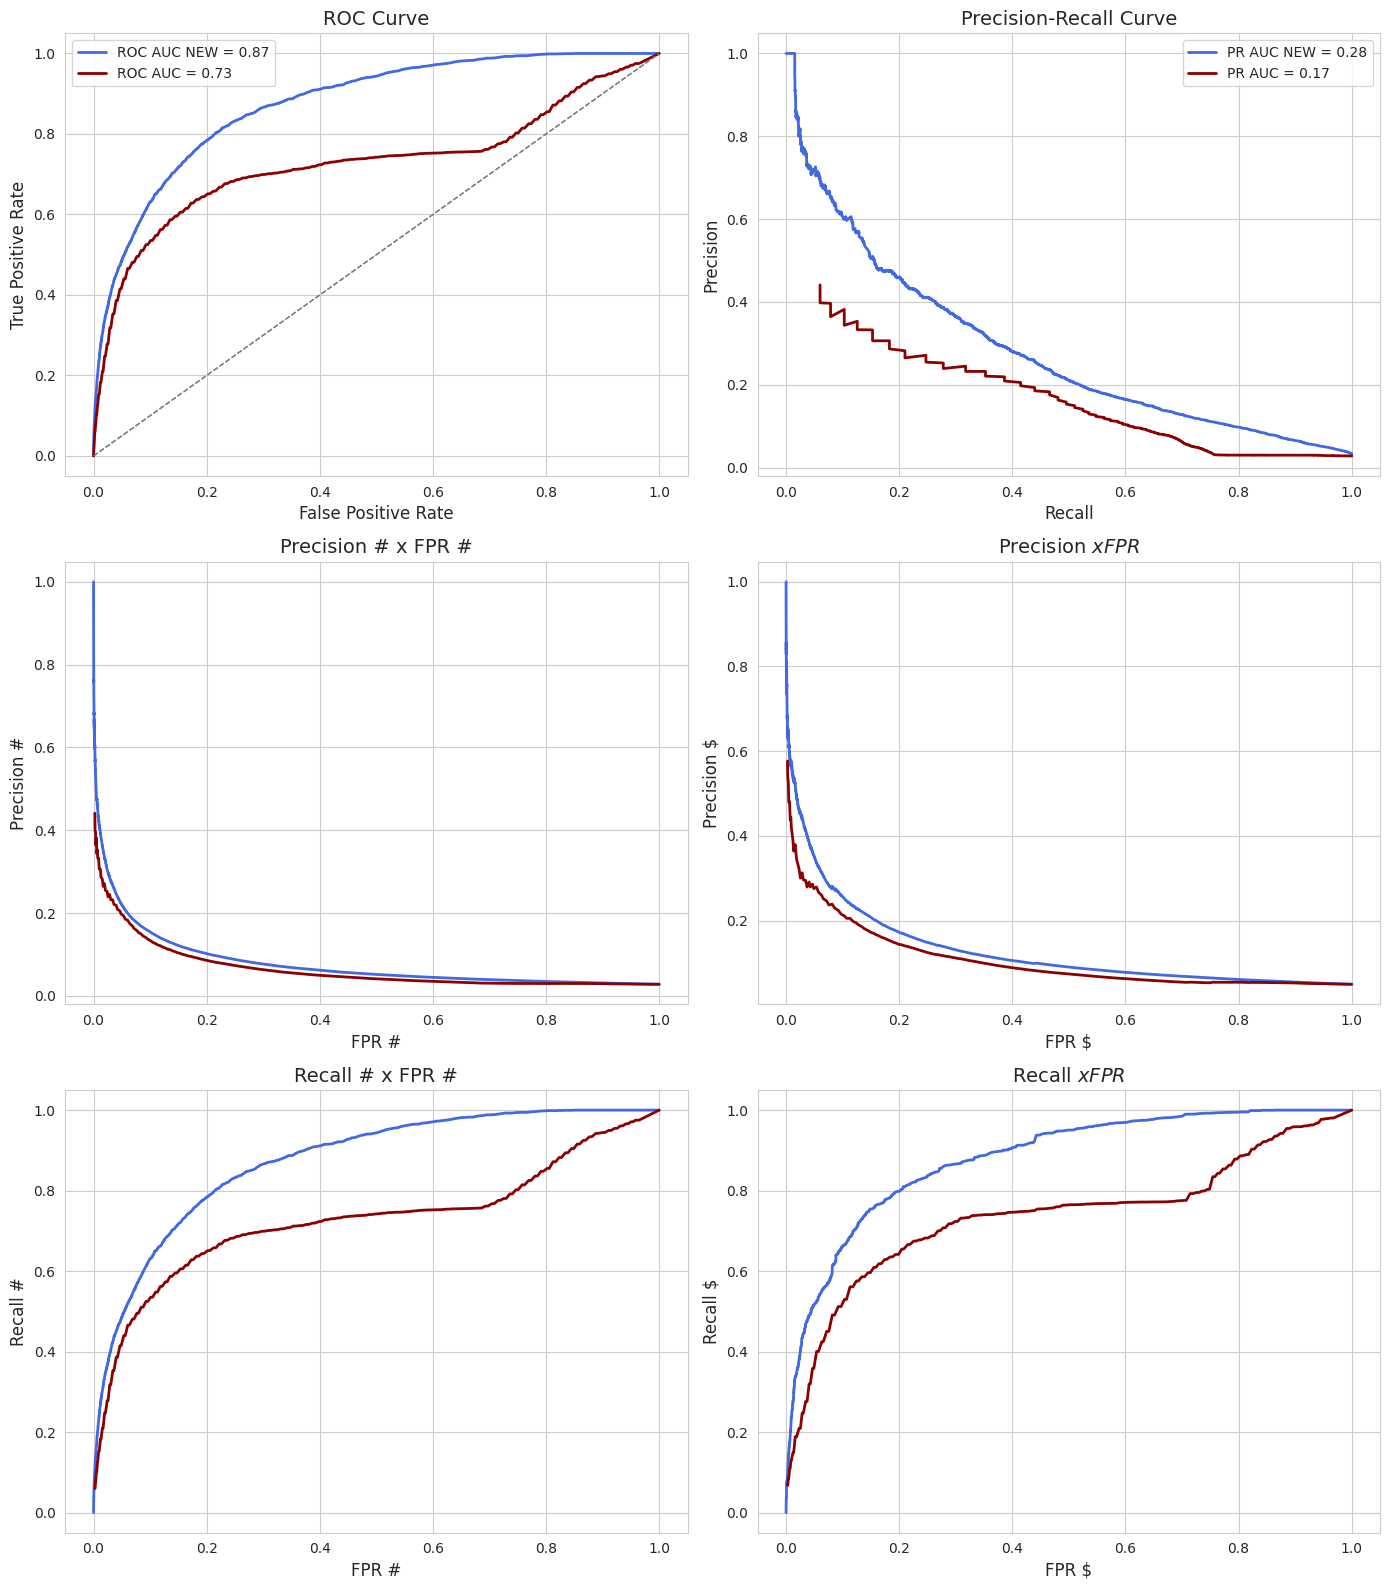

In [10]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(14, 16))
colors = ["royalblue", "darkred"]

# ROC Curve
fpr, tpr, th_roc = roc_curve(df_test['fraude'], df_test['new_score'])
roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, color=colors[0], linewidth=2, label=f'ROC AUC NEW = {roc_auc:.2f}')
axes[0, 0].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)

fpr, tpr, th_roc = roc_curve(df_test['fraude'], df_test['score'])
roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, color=colors[1], linewidth=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[0, 0].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve', fontsize=14)
axes[0, 0].legend()

# Precision-Recall Curve
pr_auc = average_precision_score(df_test['fraude'], df_test['new_score'])
axes[0, 1].plot(df_thresholds['recall_#'], df_thresholds['precision_#'], color=colors[0], linewidth=2, label=f'PR AUC NEW = {pr_auc:.2f}')

pr_auc = average_precision_score(df_test['fraude'], df_test['score'])
axes[0, 1].plot(df_thresholds_old['recall_#'], df_thresholds_old['precision_#'], color=colors[1], linewidth=2, label=f'PR AUC = {pr_auc:.2f}')
axes[0, 1].set_xlabel('Recall', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve', fontsize=14)
axes[0, 1].legend()

# Precision # x FPR #
axes[1, 0].plot(df_thresholds['fpr_#'], df_thresholds['precision_#'], color=colors[0], linewidth=2)
axes[1, 0].plot(df_thresholds_old['fpr_#'], df_thresholds_old['precision_#'], color=colors[1], linewidth=2)
axes[1, 0].set_xlabel('FPR #', fontsize=12)
axes[1, 0].set_ylabel('Precision #', fontsize=12)
axes[1, 0].set_title('Precision # x FPR #', fontsize=14)

# Precision $ x FPR $
axes[1, 1].plot(df_thresholds['fpr_$'], df_thresholds['precision_$'], color=colors[0], linewidth=2)
axes[1, 1].plot(df_thresholds_old['fpr_$'], df_thresholds_old['precision_$'], color=colors[1], linewidth=2)
axes[1, 1].set_xlabel('FPR $', fontsize=12)
axes[1, 1].set_ylabel('Precision $', fontsize=12)
axes[1, 1].set_title('Precision $ x FPR $', fontsize=14)

# Recall # x FPR #
axes[2, 0].plot(df_thresholds['fpr_#'], df_thresholds['recall_#'], color=colors[0], linewidth=2)
axes[2, 0].plot(df_thresholds_old['fpr_#'], df_thresholds_old['recall_#'], color=colors[1], linewidth=2)
axes[2, 0].set_xlabel('FPR #', fontsize=12)
axes[2, 0].set_ylabel('Recall #', fontsize=12)
axes[2, 0].set_title('Recall # x FPR #', fontsize=14)

# Recall $ x FPR $
axes[2, 1].plot(df_thresholds['fpr_$'], df_thresholds['recall_$'], color=colors[0], linewidth=2)
axes[2, 1].plot(df_thresholds_old['fpr_$'], df_thresholds_old['recall_$'], color=colors[1], linewidth=2)
axes[2, 1].set_xlabel('FPR $', fontsize=12)
axes[2, 1].set_ylabel('Recall $', fontsize=12)
axes[2, 1].set_title('Recall $ x FPR $', fontsize=14)


plt.tight_layout()
plt.show()

Comparando o novo score com o score antigo é possível notar uma melhor performance quando analisado todo o público nas métricas de ROC AUC, PR AUC, Recall e Precision quando analisado todo o público.  

In [51]:
print(f"ROCAUC New: {roc_auc_score(df_test['fraude'], df_test['new_score'])}")
print(f"ROCAUC Old: {roc_auc_score(df_test['fraude'], df_test['score'])}\n")

print(f"ROCAUC@1% New: {roc_auc_score(df_test['fraude'], df_test['new_score'], max_fpr=0.01)}")
print(f"ROCAUC@1% Old: {roc_auc_score(df_test['fraude'], df_test['score'], max_fpr=0.01)}")

ROCAUC New: 0.8760335471879123
ROCAUC Old: 0.728420266200116

ROCAUC@1% New: 0.5769499997799922
ROCAUC@1% Old: 0.5446779227955653


Avaliando pontos de impacto menores o score também tem um desempenho superior.  

### Distribuição

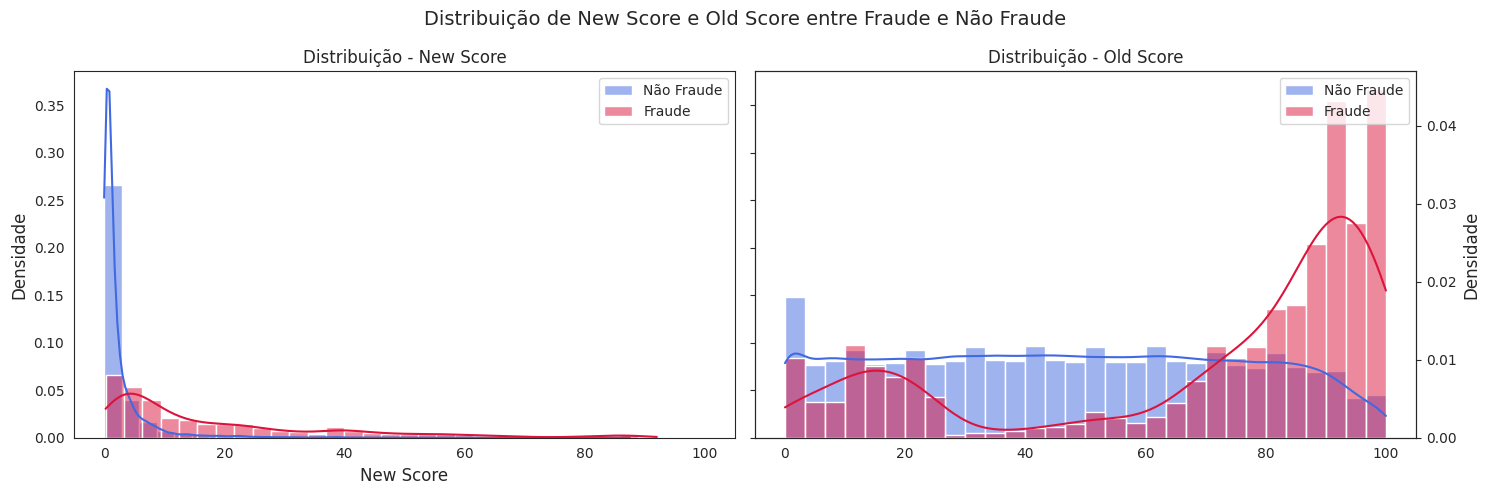

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)


sns.histplot(
    data=df[df['fraude'] == 0], x="new_score", kde=True, stat="density",
    bins=30, color="royalblue", alpha=0.5, label="Não Fraude", ax=axes[0]
)
sns.histplot(
    data=df[df['fraude'] == 1], x="new_score", kde=True, stat="density",
    bins=30, color="crimson", alpha=0.5, label="Fraude", ax=axes[0]
)
axes[0].set_title("Distribuição - New Score", fontsize=12)
axes[0].set_xlabel("New Score", fontsize=12)
axes[0].set_ylabel("Densidade", fontsize=12)
axes[0].legend(loc="upper right")

ax2 = axes[1].twinx()
sns.histplot(
    data=df[df['fraude'] == 0], x="score", kde=True, stat="density",
    bins=30, color="royalblue", alpha=0.5, label="Não Fraude", ax=ax2
)
sns.histplot(
    data=df[df['fraude'] == 1], x="score", kde=True, stat="density",
    bins=30, color="crimson", alpha=0.5, label="Fraude", ax=ax2
)
ax2.set_title("Distribuição - Old Score", fontsize=12)
ax2.set_xlabel("Old Score", fontsize=12)
ax2.set_ylabel("Densidade", fontsize=12)
ax2.legend(loc="upper right")

plt.suptitle("Distribuição de New Score e Old Score entre Fraude e Não Fraude", fontsize=14)
plt.tight_layout()
plt.show()


A distribuição do novo score também tem um formato muito diferente do antigo, acumulando muitas transações para próximo do 0, possibilitando faixas de score com menor FPR, facilitando a usabilidade em casos de baixissimo impacto no cliente final, o que não era possível com o antigo score, pois o corte 99.99 já tinha um FPR de 0.002604.  

## Avaliação ao longo do tempo

In [57]:
df['anomesdia'] = df['fecha'].astype(str).str[0:10].str.replace('-','', regex=True).astype(int)

In [59]:
df_auc_safrada = pd.DataFrame([
    [
        str(anomesdia),
        roc_auc_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['new_score']),
        average_precision_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['new_score']),
        df[df['anomesdia'] == anomesdia]['fraude'].mean(),
        df[df['anomesdia'] == anomesdia].shape[0],
        df[df['anomesdia'] == anomesdia]['fraude'].sum()
    ]
    for anomesdia in df['anomesdia'].unique()
], columns=['anomesdia', 'roc_auc', 'pr_auc', 'br', 'qtd_trans', 'qtd_fraude']).sort_values(by='anomesdia')

df_auc_safrada_old = pd.DataFrame([
    [
        str(anomesdia),
        roc_auc_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['score']),
        average_precision_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['score']),
        df[df['anomesdia'] == anomesdia]['fraude'].mean(),
        df[df['anomesdia'] == anomesdia].shape[0],
        df[df['anomesdia'] == anomesdia]['fraude'].sum()
    ]
    for anomesdia in df['anomesdia'].unique()
], columns=['anomesdia', 'roc_auc', 'pr_auc', 'br', 'qtd_trans', 'qtd_fraude']).sort_values(by='anomesdia')



In [60]:
df_auc_safrada['media_movel_roc_auc'] = df_auc_safrada['roc_auc'].rolling(window=7).mean()
df_auc_safrada['media_movel_pr_auc'] = df_auc_safrada['pr_auc'].rolling(window=7).mean()
df_auc_safrada['media_movel_br'] = df_auc_safrada['br'].rolling(window=7).mean()
df_auc_safrada['media_movel_qtd_trans'] = df_auc_safrada['qtd_trans'].rolling(window=7).mean()
df_auc_safrada['media_movel_qtd_fraude'] = df_auc_safrada['qtd_fraude'].rolling(window=7).mean()

df_auc_safrada_old['media_movel_roc_auc'] = df_auc_safrada_old['roc_auc'].rolling(window=7).mean()
df_auc_safrada_old['media_movel_pr_auc'] = df_auc_safrada_old['pr_auc'].rolling(window=7).mean()
df_auc_safrada_old['media_movel_br'] = df_auc_safrada_old['br'].rolling(window=7).mean()
df_auc_safrada_old['media_movel_qtd_trans'] = df_auc_safrada_old['qtd_trans'].rolling(window=7).mean()
df_auc_safrada_old['media_movel_qtd_fraude'] = df_auc_safrada_old['qtd_fraude'].rolling(window=7).mean()

/tmp/ipykernel_26392/3950764045.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_26392/3950764045.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_26392/3950764045.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_26392/3950764045.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_26392/3950764045.py:24: UserWarning: set_tick

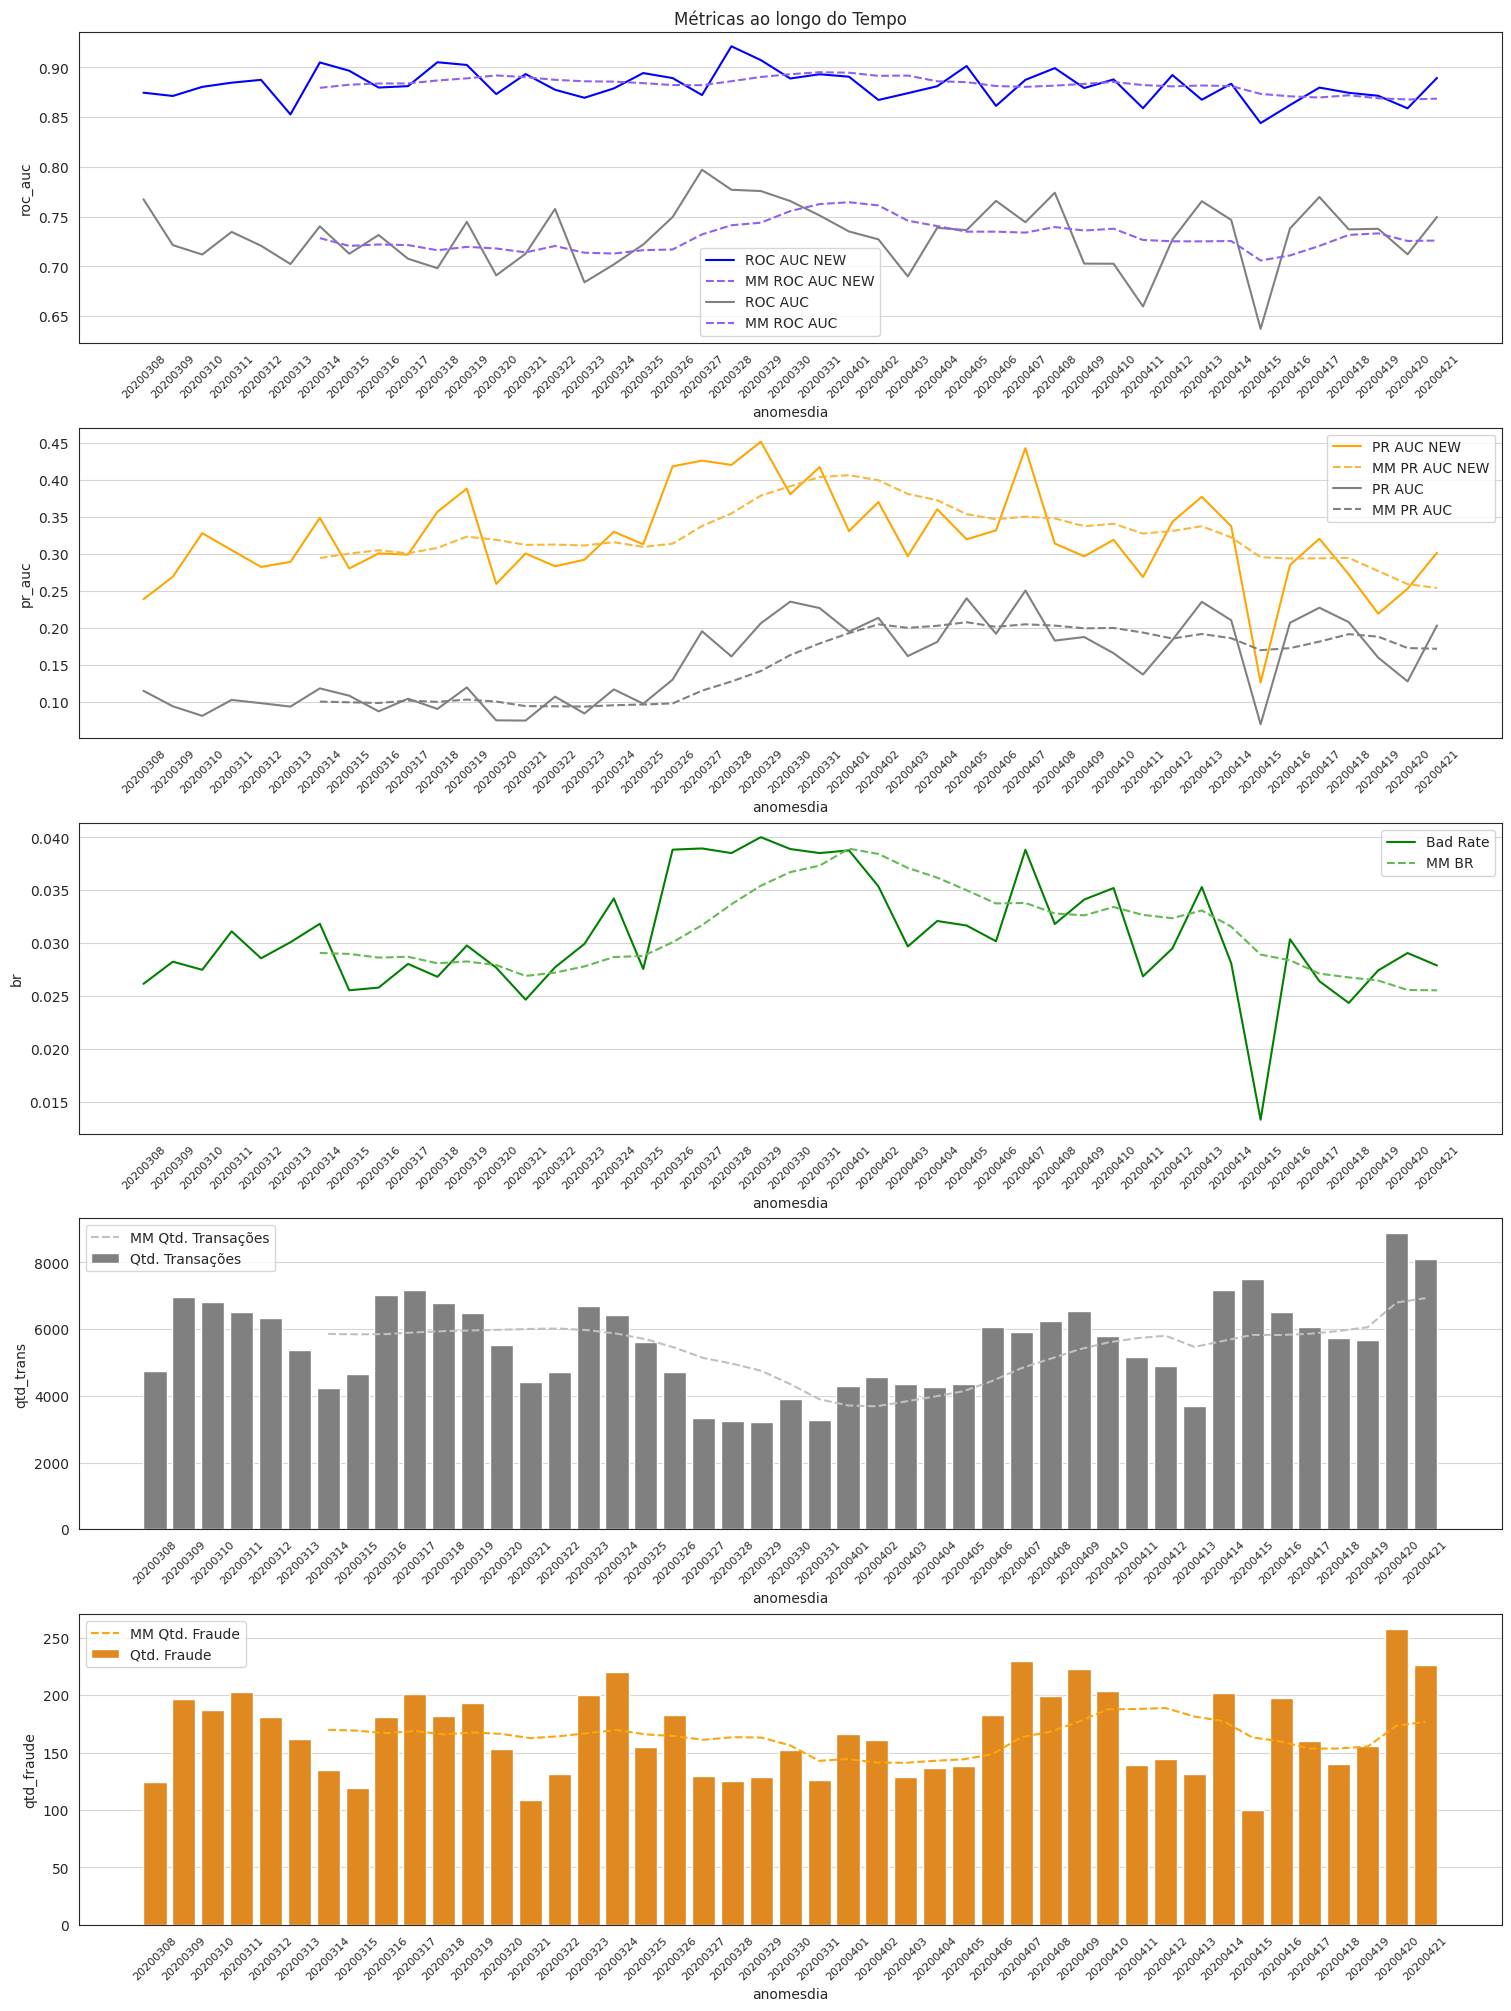

In [63]:
sns.set_style("white")

fig, axes = plt.subplots(5, 1, figsize=(15, 20),constrained_layout=True)
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='roc_auc', label='ROC AUC NEW', ax=axes[0], color='blue')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_roc_auc', label='MM ROC AUC NEW', ax=axes[0], linestyle="--", color='#8f61f3')
sns.lineplot(data=df_auc_safrada_old, x='anomesdia', y='roc_auc', label='ROC AUC', ax=axes[0], color='gray')
sns.lineplot(data=df_auc_safrada_old, x='anomesdia', y='media_movel_roc_auc', label='MM ROC AUC', ax=axes[0], linestyle="--", color='#8f61f3')

sns.lineplot(data=df_auc_safrada, x='anomesdia', y='pr_auc', label='PR AUC NEW', ax=axes[1], color='orange')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_pr_auc', label='MM PR AUC NEW', ax=axes[1], linestyle="--", color='#fbb73a')
sns.lineplot(data=df_auc_safrada_old, x='anomesdia', y='pr_auc', label='PR AUC', ax=axes[1], color='gray')
sns.lineplot(data=df_auc_safrada_old, x='anomesdia', y='media_movel_pr_auc', label='MM PR AUC', ax=axes[1], linestyle="--", color='gray')

sns.lineplot(data=df_auc_safrada, x='anomesdia', y='br', label='Bad Rate', ax=axes[2], color='green')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_br', label='MM BR', ax=axes[2], linestyle="--", color='#61bb50')

sns.barplot(data=df_auc_safrada, x='anomesdia', y='qtd_trans', label='Qtd. Transações', ax=axes[3], color='grey')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_qtd_trans', label='MM Qtd. Transações', ax=axes[3], linestyle="--", color='#c0c0c0')

sns.barplot(data=df_auc_safrada, x='anomesdia', y='qtd_fraude', label='Qtd. Fraude', ax=axes[4], color='darkorange')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_qtd_fraude', label='MM Qtd. Fraude', ax=axes[4], linestyle="--", color='#fea50d')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
    ax.grid(axis='y', linestyle="-", alpha=0.8)

axes[0].set_title('Métricas ao longo do Tempo')
plt.show()

Avaliando o comportamento ao longo do tempo o novo score também é superior ao antigo, mostrando estabilidade e consistência, sempre acompanhando a bad rate.  

### Estabilidade do Score

In [59]:
# Vou utilizar como referência a primeira semana do dataset

ks_day_map = {
    'Sunday' : 20200308,
    'Monday' : 20200309,
    'Tuesday' : 20200310,
    'Wednesday' : 20200311,
    'Thursday' : 20200312,
    'Friday' : 20200313,
    'Saturday' : 20200314
}

df_ks_safrado = pd.DataFrame(
    [
        [
            str(anomesdia),
            kstest(df[df['anomesdia'] == ks_day_map.get(datetime.strptime(str(anomesdia), "%Y%m%d").strftime("%A"))]['new_score'], 
                   df[df['anomesdia'] == anomesdia]['new_score'])[0]
        ]
        for anomesdia in df['anomesdia'].unique() if int(anomesdia) >= 20200315
    ],
    columns=['anomesdia', 'ks']
).sort_values(by='anomesdia')

In [60]:
df['faixa_score'] = pd.cut(df['new_score'], bins=range(0, 100, 5), include_lowest=True)
df_grouped = df[df['anomesdia'] >= 20200315].groupby(['anomesdia', 'faixa_score']).size().unstack().fillna(0)
df_percentual = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
df_percentual.index = df_percentual.index.astype(str)

/tmp/ipykernel_8881/1463839929.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df[df['anomesdia'] >= 20200315].groupby(['anomesdia', 'faixa_score']).size().unstack().fillna(0)


/tmp/ipykernel_8881/124477336.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)


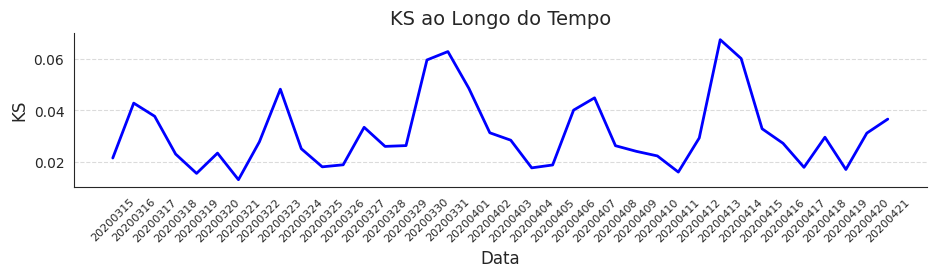

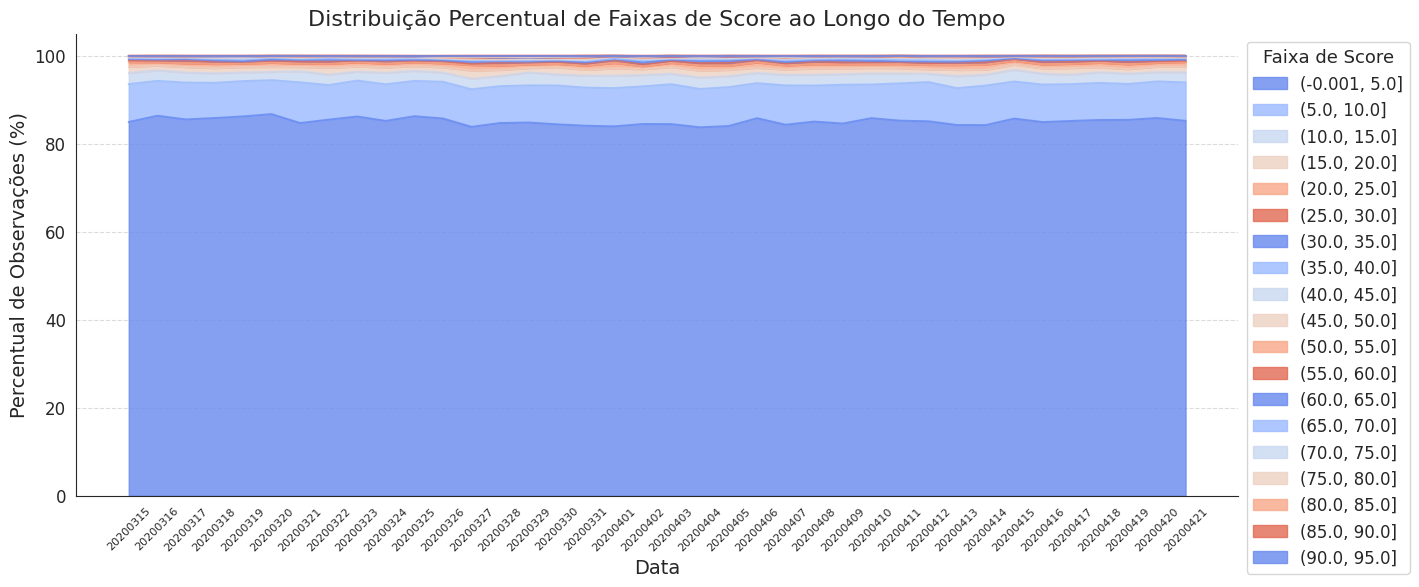

In [63]:
# KS
plt.figure(figsize=(11, 2))

sns.set_palette("coolwarm")

ax = sns.lineplot(data=df_ks_safrado, x='anomesdia', y='ks', linewidth=2, color='blue')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)

ax.set_title('KS ao Longo do Tempo', fontsize=14)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('KS', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Distribuição Faixas de Score
ax = df_percentual.plot(kind='area', stacked=True, figsize=(15, 6), alpha=0.8)

plt.xlabel("Data", fontsize=14)
plt.ylabel("Percentual de Observações (%)", fontsize=14)
plt.title("Distribuição Percentual de Faixas de Score ao Longo do Tempo", fontsize=16)

plt.xticks(ticks=np.arange(len(df_percentual.index)), labels=df_percentual.index, rotation=45, fontsize=8)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(title="Faixa de Score", fontsize=12, title_fontsize=13, loc='upper left', bbox_to_anchor=(1, 1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

Avaliando um teste de estabilidade, o novo score demonstra sazonalidades na métrica do KS, porêm se mantêm constrolado com KS <= 0.06.  

# Explicabilidade

In [79]:
df_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)
df_importance['importance_cumsum'] = df_importance['importance'].cumsum()
df_importance['importance_perc'] = df_importance['importance_cumsum'] / df_importance['importance_cumsum'].max()
df_importance

,feature,importance,importance_cumsum,importance_perc
0,o,74671.689317,74671.689317,0.444462
1,a,28756.051693,103427.741010,0.615624
2,m,12565.067020,115992.808030,0.690414
3,f,11838.330136,127831.138166,0.760878
4,l,11496.030424,139327.168590,0.829305
5,br_qty_cat_last7d,9219.616182,148546.784772,0.884182
6,h,7520.252725,156067.037497,0.928945
7,d,3570.905270,159637.942767,0.950199
8,n,3492.789016,163130.731783,0.970989
9,vl_fraud_cat_last7d,2293.877333,165424.609116,0.984643


In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(df[model.feature_names_in_])

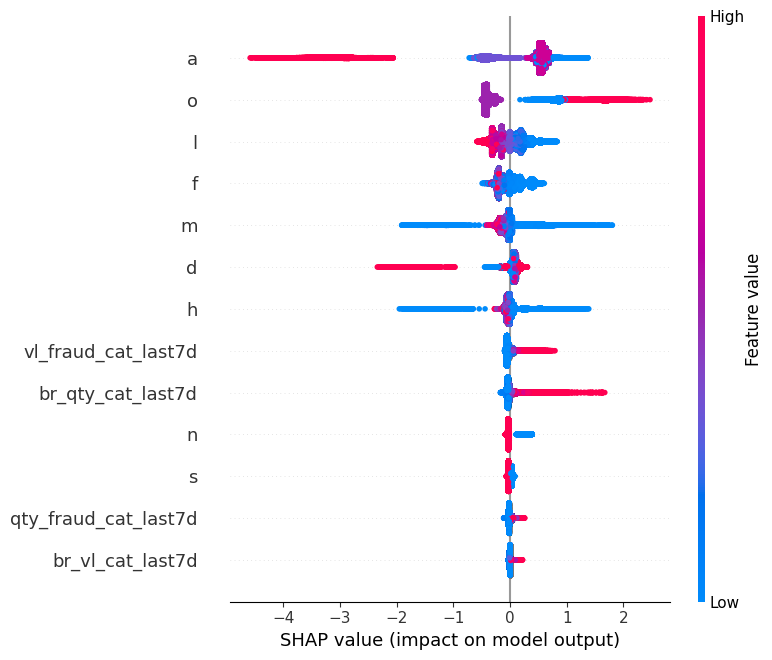

In [14]:
shap.summary_plot(shap_values, df[model.feature_names_in_])

Como não temos o que é cada coluna, não conseguimos explicar muito bem o que impacta positivamente e negativament o score. Porêm as colunas que construimos, sobre distribuições de fraude e total de transações por categoria de produto conseguimos descrever.  
Ambas as colunas de quantidade de fraude e valor de fraude entraram no modelo e tiveram o comportamento esperado, tem uma distribuição próxima do 0, indicando que poucas categorias tem fraude, porém quanto maior o seu valor, maior a chance de ocorrerem fraudes nesse produto, impactando positivamente no score.  